# Development notes

Actions:
* Right now word to vec will use all data to train its embeddings. This should probably be validated by a train, test, validate split.
* Why do I use Adam for my skip gram
* Move the margin in the two tower to be a hyper parameter.

# Step 0a - Configuration

In [ ]:
# Install dependencies
!pip install datasets
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install sentencepiece
!pip install scikit-learn
!pip install matplotlib
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 86.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 72.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.6 MB/s eta 0:00:00


In [44]:
# Configuration
should_use_small_data = False
corpus_filename = "./datasets/ms_marco_corpus.txt"
weights_output_path = "skipgram_weights"

sentencepiece_model_prefix = "ms_marco"
sentencepiece_model_file_name = sentencepiece_model_prefix + ".model"

# Hyper parameters
sentence_piece_vocab_size = 10000

# Word2Vec hyper parameters
embedding_feature_dimension = 128
window_size =2
learning_rate = 0.01
skipgram_epochs = 100
batch_size = 32

# Two tower hyper parameters
two_tower_hidden_size = 128 
vocab_size = 10000
two_tower_learning_rate = 0.001
two_tower_training_epochs = 3 

# Step 0 - Load dependencies

In [ ]:
import os
import sentencepiece as spm
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm

import random

from gensim.models import Word2Vec

if torch.cuda.is_available():
    print("CUDA is available. GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CUDA is available. GPU: NVIDIA A30
Using device: cuda


# Step 1 - Load the datasets

In [46]:
datasets_list = list_datasets()
ms_df_dict = load_dataset("ms_marco", "v1.1")
ms_train_df = ms_df_dict['train']
ms_validation_df = ms_df_dict['validation']
ms_test_df = ms_df_dict['test']

# Convert to Pandas
ms_train_df = pd.DataFrame(ms_train_df)
ms_validation_df = pd.DataFrame(ms_validation_df)
ms_test_df = pd.DataFrame(ms_test_df)

if should_use_small_data: 
    # Setup a smaller dataset for debugging purposes
    print("Running with smaller datasets enabled")
    ms_train_df = ms_train_df.iloc[0:1000]
    ms_validation_df = ms_validation_df.iloc[0:600]
    ms_test_df = ms_test_df[0:200]

# Step X - Sentence piece preparation

First we create the corpus from the combination from the combination of the the queries and the documents (both positive and negative)

In [48]:
query_string = "query"
passage_string = "passages"
passage_text_string = "passage_text"

# Gather all of queries into one list
all_queries = list(ms_train_df[query_string]) + list(ms_validation_df[query_string]) + list(ms_test_df[query_string])

assert (len(all_queries) == len(ms_train_df) + len(ms_validation_df) + len(ms_test_df))

# Helper function for reading out the data from a given container.
def read_passage_texts_from_data(data_frame):
    passages = data_frame[passage_string]
    texts = [passage[passage_text_string] for passage in passages]
    return texts

train_texts = read_passage_texts_from_data(ms_train_df)
test_texts = read_passage_texts_from_data(ms_test_df)
validation_texts = read_passage_texts_from_data(ms_validation_df)

# Now lets read out all of documents for the corpus
def read_all_documents(data_frame):
    return [entry for passage in data_frame[passage_string] for entry in passage[passage_text_string]]

all_documents = read_all_documents(ms_train_df) + read_all_documents(ms_test_df) + read_all_documents(ms_validation_df)

corpus = all_queries + all_documents

Write the corpus to a file for preview

In [49]:
with open(corpus_filename, "w") as corpus_file:
    for sentence in corpus:
        corpus_file.write(sentence + os.linesep)

Train and generate the sentence piece model using the corpus text

In [ ]:
spm.SentencePieceTrainer.train(input=corpus_filename, model_prefix=sentencepiece_model_prefix, vocab_size=sentence_piece_vocab_size)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./datasets/ms_marco_corpus.txt
  input_format: 
  model_prefix: ms_marco
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential

Step X - Generate tokens for the queries and the documents using sentence piece model

In [ ]:
sp_model = spm.SentencePieceProcessor()
sp_model.load(sentencepiece_model_file_name)

tokenized_queries = [sp_model.encode_as_pieces(query) for query in all_queries]

id_queries = [[sp_model.piece_to_id(token) for token in query_tokens] for query_tokens in tokenized_queries]

print(tokenized_queries)
print(id_queries)

[['▁what', '▁is', '▁r', 'ba'], ['▁was', '▁r', 'onald', '▁re', 'a', 'g', 'an', '▁a', '▁democrat'], ['▁how', '▁long', '▁do', '▁you', '▁need', '▁for', '▁s', 'y', 'd', 'ney', '▁and', '▁surrounding', '▁areas'], ['▁price', '▁to', '▁install', '▁tile', '▁in', '▁shower'], ['▁why', '▁conversion', '▁observed', '▁in', '▁body'], ['▁where', '▁are', '▁the', '▁lungs', '▁located', '▁in', '▁the', '▁back'], ['▁cost', '▁to', '▁get', '▁a', '▁patent'], ['▁what', '▁does', '▁a', '▁metabolic', '▁acidosis', '▁need', '▁to', '▁reverse', '▁the', '▁condition'], ['▁best', '▁t', 'rag', 'ed', 'ies', '▁of', '▁an', 'cient', '▁gr', 'ee', 'ce'], ['▁what', '▁is', '▁a', '▁conifer'], ['▁in', '▁animals', '▁so', 'matic', '▁cells', '▁are', '▁produced', '▁by', '▁and', '▁game', 'tic', '▁cells', '▁are', '▁produced', '▁by'], ['▁remember', 'ing', '▁the', '▁name', '▁of', '▁the', '▁author', '▁who', '▁wrote', '▁the', '▁cat', '▁in', '▁the', '▁hat'], ['▁how', '▁long', '▁cooking', '▁chicken', '▁legs', '▁in', '▁the', '▁big', '▁easy'], ['▁a

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./datasets/ms_marco_corpus.txt
  input_format: 
  model_prefix: ms_marco
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential

# Step X - Skipgram Word2Vec model implementation

Helper class to prepare the input data to the Skipgram model

In [53]:
def generate_skip_gram_pairs(tokenized_sentences, window_size=2):
    pairs = []
    for sentence in tokenized_sentences:
        for center_word_pos in range(len(sentence)):
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                if context_word_pos < 0 or context_word_pos >= len(sentence) or center_word_pos == context_word_pos:
                    continue
                center_word_index = sentence[center_word_pos]
                context_word_index = sentence[context_word_pos]
                pairs.append((center_word_index, context_word_index))
    return pairs

class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
        center, context = self.pairs[index]
        return torch.tensor(center, dtype=torch.long), torch.tensor(context, dtype=torch.long)
    
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dimension):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dimension)
        self.linear = nn.Linear(embedding_dimension, vocab_size)

    def forward(self, target_word):
        embedded = self.embeddings(target_word)
        out = self.linear(embedded)
        log_probabilities = nn.functional.log_softmax(out, dim = 1)
        return log_probabilities


# Step X - Skipgram embeddings trainings

In [54]:
training_queries = list(ms_train_df[query_string])
training_tokenized_queries = [sp_model.encode_as_pieces(query) for query in training_queries]
training_id_queries = [[sp_model.piece_to_id(token) for token in query_tokens] for query_tokens in training_tokenized_queries]

skipgram_pairs_train = generate_skip_gram_pairs(training_id_queries, window_size)
skipgram_dataset_train = SkipGramDataset(skipgram_pairs_train)
skipgram_dataloader_train = DataLoader(skipgram_dataset_train, batch_size=batch_size, shuffle=True)

# Setup validation data
validation_queries = list(ms_validation_df[query_string])
validation_tokenized_queries = [sp_model.encode_as_pieces(query) for query in validation_queries]
validation_id_queries = [[sp_model.piece_to_id(token) for token in query_tokens] for query_tokens in validation_tokenized_queries]

skipgram_pairs_validation = generate_skip_gram_pairs(validation_id_queries, window_size)
skipgram_dataset_validation = SkipGramDataset(skipgram_pairs_validation)
skipgram_dataloader_validation = DataLoader(skipgram_dataset_validation, batch_size=batch_size, shuffle=True)

skipgram_model = SkipGramModel(sentence_piece_vocab_size, embedding_feature_dimension).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(skipgram_model.parameters(), lr = learning_rate)

if not os.path.exists(weights_output_path):
    os.makedirs(weights_output_path)

for epoch in range(skipgram_epochs):
    skipgram_model.train()
    total_loss = 0
    for center_word, context_word in tqdm(skipgram_dataloader_train, desc=f"Epoch {epoch+1}"):
        center_word, context_word = center_word.to(device), context_word.to(device)  # Move data to the GPU

        optimizer.zero_grad()
        log_probs = skipgram_model(center_word)
        loss = loss_function(log_probs, context_word)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    average_loss = total_loss / len(skipgram_dataloader_train)
    print(f"Epoch {epoch+1}: Training Total Loss = {total_loss}, Average loss = {average_loss}")

    # do the validation
    skipgram_model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No gradients needed for validation
        for center_word, context_word in tqdm(skipgram_dataloader_validation, desc=f"Validation Epoch {epoch+1}"):
            center_word, context_word = center_word.to(device), context_word.to(device)

            log_probs = skipgram_model(center_word)
            val_loss = loss_function(log_probs, context_word)

            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(skipgram_dataloader_validation)
    print(f"Epoch {epoch+1}: Validation Total Loss = {total_val_loss}, Average Loss = {average_val_loss}")


    torch.save(skipgram_model.state_dict(), os.path.join(weights_output_path, f"skip_gram_model_weights_epoch_{epoch+1}.pth"))
    

Epoch 1: 100%|██████████| 64936/64936 [01:53<00:00, 573.85it/s]


Epoch 1: Training Total Loss = 454921.5518016815, Average loss = 7.005691015795268


Validation Epoch 1: 100%|██████████| 7926/7926 [00:04<00:00, 1602.46it/s]


Epoch 1: Validation Total Loss = 54677.22281265259, Average Loss = 6.898463640253922


Epoch 2: 100%|██████████| 64936/64936 [01:54<00:00, 567.61it/s]


Epoch 2: Training Total Loss = 444967.65369176865, Average loss = 6.852403192247269


Validation Epoch 2: 100%|██████████| 7926/7926 [00:04<00:00, 1593.21it/s]


Epoch 2: Validation Total Loss = 54461.04349708557, Average Loss = 6.871188934782434


Epoch 3: 100%|██████████| 64936/64936 [01:53<00:00, 571.15it/s]


Epoch 3: Training Total Loss = 444568.9415779114, Average loss = 6.846263114110992


Validation Epoch 3: 100%|██████████| 7926/7926 [00:04<00:00, 1624.93it/s]


Epoch 3: Validation Total Loss = 54552.4954123497, Average Loss = 6.882727152706245


Epoch 4: 100%|██████████| 64936/64936 [01:52<00:00, 578.80it/s]


Epoch 4: Training Total Loss = 444561.5686559677, Average loss = 6.846149572748055


Validation Epoch 4: 100%|██████████| 7926/7926 [00:05<00:00, 1583.28it/s]


Epoch 4: Validation Total Loss = 54586.0197057724, Average Loss = 6.886956813748726


Epoch 5: 100%|██████████| 64936/64936 [01:52<00:00, 579.45it/s]


Epoch 5: Training Total Loss = 444467.72065258026, Average loss = 6.844704334307322


Validation Epoch 5: 100%|██████████| 7926/7926 [00:05<00:00, 1581.46it/s]


Epoch 5: Validation Total Loss = 54455.770652770996, Average Loss = 6.870523675595634


Epoch 6: 100%|██████████| 64936/64936 [01:52<00:00, 577.70it/s]


Epoch 6: Training Total Loss = 444521.1243748665, Average loss = 6.845526739787891


Validation Epoch 6: 100%|██████████| 7926/7926 [00:04<00:00, 1594.30it/s]


Epoch 6: Validation Total Loss = 54437.93398141861, Average Loss = 6.868273275475475


Epoch 7: 100%|██████████| 64936/64936 [01:51<00:00, 584.05it/s]


Epoch 7: Training Total Loss = 444482.2984290123, Average loss = 6.844928828831654


Validation Epoch 7: 100%|██████████| 7926/7926 [00:04<00:00, 1597.32it/s]


Epoch 7: Validation Total Loss = 54546.588347911835, Average Loss = 6.881981875840504


Epoch 8: 100%|██████████| 64936/64936 [01:52<00:00, 578.32it/s]


Epoch 8: Training Total Loss = 444496.19384527206, Average loss = 6.845142815160651


Validation Epoch 8: 100%|██████████| 7926/7926 [00:04<00:00, 1615.95it/s]


Epoch 8: Validation Total Loss = 54715.08549499512, Average Loss = 6.903240663007207


Epoch 9: 100%|██████████| 64936/64936 [01:52<00:00, 578.84it/s]


Epoch 9: Training Total Loss = 444559.04246759415, Average loss = 6.846110670007302


Validation Epoch 9: 100%|██████████| 7926/7926 [00:04<00:00, 1591.65it/s]


Epoch 9: Validation Total Loss = 54788.37639570236, Average Loss = 6.9124875593871264


Epoch 10: 100%|██████████| 64936/64936 [01:52<00:00, 578.83it/s]


Epoch 10: Training Total Loss = 444469.27546930313, Average loss = 6.844728278140063


Validation Epoch 10: 100%|██████████| 7926/7926 [00:04<00:00, 1620.36it/s]


Epoch 10: Validation Total Loss = 54709.36902523041, Average Loss = 6.902519432908202


Epoch 11: 100%|██████████| 64936/64936 [01:52<00:00, 575.67it/s]


Epoch 11: Training Total Loss = 444540.0350828171, Average loss = 6.845817960496752


Validation Epoch 11: 100%|██████████| 7926/7926 [00:04<00:00, 1620.01it/s]


Epoch 11: Validation Total Loss = 54588.60141324997, Average Loss = 6.8872825401526585


Epoch 12: 100%|██████████| 64936/64936 [01:52<00:00, 575.21it/s]


Epoch 12: Training Total Loss = 444517.77276802063, Average loss = 6.845475125785707


Validation Epoch 12: 100%|██████████| 7926/7926 [00:04<00:00, 1629.45it/s]


Epoch 12: Validation Total Loss = 54632.900611400604, Average Loss = 6.892871639086627


Epoch 13: 100%|██████████| 64936/64936 [01:52<00:00, 577.72it/s]


Epoch 13: Training Total Loss = 444457.31846380234, Average loss = 6.844544142906898


Validation Epoch 13: 100%|██████████| 7926/7926 [00:04<00:00, 1630.55it/s]


Epoch 13: Validation Total Loss = 54603.92182302475, Average Loss = 6.889215470984702


Epoch 14: 100%|██████████| 64936/64936 [01:52<00:00, 576.19it/s]


Epoch 14: Training Total Loss = 444562.00333213806, Average loss = 6.8461562666646865


Validation Epoch 14: 100%|██████████| 7926/7926 [00:04<00:00, 1623.61it/s]


Epoch 14: Validation Total Loss = 54591.89508008957, Average Loss = 6.887698092365578


Epoch 15: 100%|██████████| 64936/64936 [01:52<00:00, 578.28it/s]


Epoch 15: Training Total Loss = 444512.56292438507, Average loss = 6.845394895349037


Validation Epoch 15: 100%|██████████| 7926/7926 [00:04<00:00, 1622.06it/s]


Epoch 15: Validation Total Loss = 54587.15795183182, Average Loss = 6.8871004228907164


Epoch 16: 100%|██████████| 64936/64936 [01:51<00:00, 583.39it/s]


Epoch 16: Training Total Loss = 444574.07240867615, Average loss = 6.846342127766973


Validation Epoch 16: 100%|██████████| 7926/7926 [00:04<00:00, 1597.16it/s]


Epoch 16: Validation Total Loss = 54570.38614463806, Average Loss = 6.884984373534956


Epoch 17: 100%|██████████| 64936/64936 [01:53<00:00, 570.05it/s]


Epoch 17: Training Total Loss = 444619.06471061707, Average loss = 6.847034999239514


Validation Epoch 17: 100%|██████████| 7926/7926 [00:04<00:00, 1596.48it/s]


Epoch 17: Validation Total Loss = 54636.27957868576, Average Loss = 6.893297953404714


Epoch 18: 100%|██████████| 64936/64936 [01:50<00:00, 586.07it/s]


Epoch 18: Training Total Loss = 444577.3666267395, Average loss = 6.846392857994633


Validation Epoch 18: 100%|██████████| 7926/7926 [00:04<00:00, 1639.44it/s]


Epoch 18: Validation Total Loss = 54603.52858686447, Average Loss = 6.8891658575403065


Epoch 19: 100%|██████████| 64936/64936 [01:52<00:00, 576.66it/s]


Epoch 19: Training Total Loss = 444507.6238293648, Average loss = 6.845318834381002


Validation Epoch 19: 100%|██████████| 7926/7926 [00:04<00:00, 1627.99it/s]


Epoch 19: Validation Total Loss = 54424.20214986801, Average Loss = 6.866540770863994


Epoch 20: 100%|██████████| 64936/64936 [01:52<00:00, 579.31it/s]


Epoch 20: Training Total Loss = 444506.96772766113, Average loss = 6.845308730560261


Validation Epoch 20: 100%|██████████| 7926/7926 [00:04<00:00, 1620.19it/s]


Epoch 20: Validation Total Loss = 54605.7919549942, Average Loss = 6.889451420009362


Epoch 21: 100%|██████████| 64936/64936 [01:50<00:00, 587.63it/s]


Epoch 21: Training Total Loss = 444505.8222837448, Average loss = 6.84529109097796


Validation Epoch 21: 100%|██████████| 7926/7926 [00:04<00:00, 1626.98it/s]


Epoch 21: Validation Total Loss = 54689.72045946121, Average Loss = 6.900040431423317


Epoch 22: 100%|██████████| 64936/64936 [01:50<00:00, 585.55it/s]


Epoch 22: Training Total Loss = 444535.41892051697, Average loss = 6.845746872620995


Validation Epoch 22: 100%|██████████| 7926/7926 [00:04<00:00, 1588.18it/s]


Epoch 22: Validation Total Loss = 54611.37368488312, Average Loss = 6.8901556503763715


Epoch 23: 100%|██████████| 64936/64936 [01:53<00:00, 571.62it/s]


Epoch 23: Training Total Loss = 444571.2585425377, Average loss = 6.8462987948524345


Validation Epoch 23: 100%|██████████| 7926/7926 [00:04<00:00, 1628.45it/s]


Epoch 23: Validation Total Loss = 54571.86328077316, Average Loss = 6.8851707394364325


Epoch 24: 100%|██████████| 64936/64936 [01:52<00:00, 579.33it/s]


Epoch 24: Training Total Loss = 444549.7100930214, Average loss = 6.845966953508399


Validation Epoch 24: 100%|██████████| 7926/7926 [00:04<00:00, 1592.35it/s]


Epoch 24: Validation Total Loss = 54785.0501909256, Average Loss = 6.912067901958819


Epoch 25: 100%|██████████| 64936/64936 [01:52<00:00, 579.65it/s]


Epoch 25: Training Total Loss = 444608.5624566078, Average loss = 6.846873266856718


Validation Epoch 25: 100%|██████████| 7926/7926 [00:04<00:00, 1632.95it/s]


Epoch 25: Validation Total Loss = 54636.903904914856, Average Loss = 6.89337672280026


Epoch 26: 100%|██████████| 64936/64936 [01:52<00:00, 577.61it/s]


Epoch 26: Training Total Loss = 444586.8641843796, Average loss = 6.846539118276143


Validation Epoch 26: 100%|██████████| 7926/7926 [00:04<00:00, 1628.16it/s]


Epoch 26: Validation Total Loss = 54777.420553684235, Average Loss = 6.9111052931723735


Epoch 27: 100%|██████████| 64936/64936 [01:50<00:00, 585.53it/s]


Epoch 27: Training Total Loss = 444642.1278438568, Average loss = 6.847390166376999


Validation Epoch 27: 100%|██████████| 7926/7926 [00:04<00:00, 1598.35it/s]


Epoch 27: Validation Total Loss = 54588.88049316406, Average Loss = 6.8873177508407855


Epoch 28: 100%|██████████| 64936/64936 [01:53<00:00, 570.60it/s]


Epoch 28: Training Total Loss = 444554.5940423012, Average loss = 6.846042165244259


Validation Epoch 28: 100%|██████████| 7926/7926 [00:04<00:00, 1595.79it/s]


Epoch 28: Validation Total Loss = 54744.025337696075, Average Loss = 6.906891917448407


Epoch 29: 100%|██████████| 64936/64936 [01:52<00:00, 577.23it/s]


Epoch 29: Training Total Loss = 444609.6156716347, Average loss = 6.8468894861345735


Validation Epoch 29: 100%|██████████| 7926/7926 [00:04<00:00, 1591.45it/s]


Epoch 29: Validation Total Loss = 54640.06884479523, Average Loss = 6.8937760339131


Epoch 30: 100%|██████████| 64936/64936 [01:51<00:00, 580.84it/s]


Epoch 30: Training Total Loss = 444634.0584731102, Average loss = 6.847265899856939


Validation Epoch 30: 100%|██████████| 7926/7926 [00:04<00:00, 1592.49it/s]


Epoch 30: Validation Total Loss = 54612.78495979309, Average Loss = 6.890333706761682


Epoch 31:  23%|██▎       | 14980/64936 [00:25<01:25, 582.90it/s]


KeyboardInterrupt: 

Visualize the results of the embeddings using t-SNE

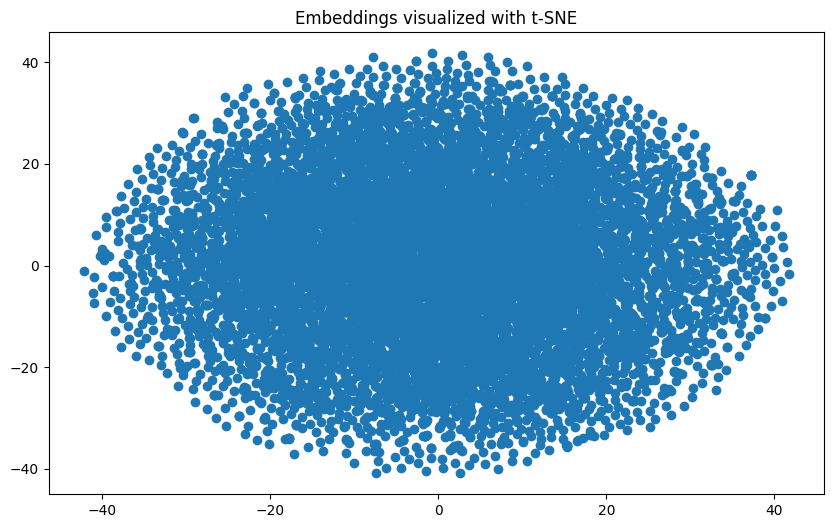

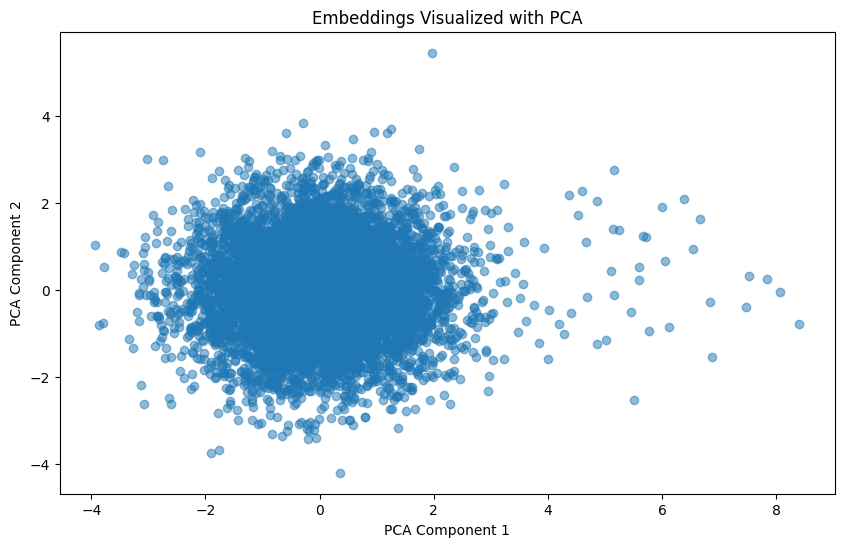

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

embeddings = skipgram_model.embeddings.weight.data.cpu().numpy()
# Assume embeddings is a matrix of your embeddings
embeddings_tsne = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.title("Embeddings visualized with t-SNE")
plt.show()

# Initialize PCA transformer with 2 components (for 2D visualization)
pca = PCA(n_components=2)

# Fit PCA on the embeddings and transform the embeddings to 2D
embeddings_2d = pca.fit_transform(embeddings)

# Plot the transformed embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)  # alpha for point transparency
plt.title("Embeddings Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Step X - Gensim backup

Weight generation via gensim as a backup, if the word2vec doesn't work.

In [ ]:
word2vec_model = Word2Vec(all_queries, vector_size=embedding_feature_dimension, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec.model")

def tokens_to_embeddings(tokenized_sentences, word2vec_model):
    embeddings = []
    for sentence in tokenized_sentences:
        sentence_embedding = []
        for token in sentence:
            if token in word2vec_model.wv:
                sentence_embedding.append(word2vec_model.wv[token])
            else:
                # Handle OOV words, e.g., by using a zero vector
                sentence_embedding.append([0] * embedding_feature_dimension)
        embeddings.append(sentence_embedding)
    return torch.tensor(embeddings, dtype=torch.float)

# Example usage
tokenized_query =
query_embeddings = tokens_to_embeddings(tokenized_query, word2vec_model)

print(query_embeddings)

# Step X - Prepare the queries using the embeddings for use with the query encoding RNN

First we start off with reading in the embeddings in our model:

In [159]:
skipgram_embeddings_file_path = os.path.join(weights_output_path, f"skip_gram_model_weights_epoch_10.pth")

state_dict = torch.load(skipgram_embeddings_file_path)
embedding_weights_tensor = state_dict['embeddings.weight']

skipgram_embeddings = nn.Embedding(sentence_piece_vocab_size, embedding_feature_dimension)
skipgram_embeddings.weight.data.copy_(embedding_weights_tensor)
skipgram_embeddings.weight.requires_grad = False

Let's create a helper function that helps us genreate tensors of padded embeddings matching the input tokens

Next, using this helper function, we create the inputs for train, test and validate groups

In [205]:
# First we read out the queries and encode them to tokens

def tokenize_entry(entry):
    # Tokenize a single entry using the loaded SentencePiece model
    return sp_model.EncodeAsIds(entry)

def generate_triplets_from_dataset(dataset):
    flat_data = []
    # Step 1: Flatten the data
    for index, row in dataset.iterrows():
        for passage in row['passages']['passage_text']:
            flat_data.append((row['query'], passage))

    print(f"Total flat data entries: {len(flat_data)}")

    # Generating a pool of all passages for selecting negatives
    all_passages = [item[1] for item in flat_data]

    triplets = []
    # Step 2: Generate triplets
    for query, positive in flat_data:
        # Exclude current query's passages from the pool of possible negatives
        possible_negatives = [passage for passage in all_passages if passage != positive]
        if possible_negatives:
            negative_document = random.choice(possible_negatives)
        else:
            # Handle unlikely case where no negative document is available
            negative_document = None
        
        triplets.append((query, positive, negative_document))

    # Convert to DataFrame
    triplets_df = pd.DataFrame(triplets, columns=['query', 'positive_document', 'negative_document'])

    # Step 3: Tokenize each entry in the DataFrame
    triplets_df['query_tokenized'] = triplets_df['query'].apply(tokenize_entry)
    triplets_df['positive_document_tokenized'] = triplets_df['positive_document'].apply(tokenize_entry)
    triplets_df['negative_document_tokenized'] = triplets_df['negative_document'].apply(lambda x: tokenize_entry(x) if x is not None else [])

    return triplets_df

# Assuming dataset is your DataFrame and sp_model is loaded
# dataset = ...
# sp_model = ...
triplets_df = generate_triplets_from_dataset(ms_train_df)

print(triplets_df.head())
print(f"Output table dimensions: {triplets_df.shape}")

Total flat data entries: 8251
         query                                  positive_document  \
0  what is rba  Since 2007, the RBA's outstanding reputation h...   
1  what is rba  The Reserve Bank of Australia (RBA) came into ...   
2  what is rba  RBA Recognized with the 2014 Microsoft US Regi...   
3  what is rba  The inner workings of a rebuildable atomizer a...   
4  what is rba  Results-Based Accountability® (also known as R...   

                                   negative_document      query_tokenized  \
0  You need protein for your muscles, bones, and ...  [95, 11, 559, 1255]   
1  Causes. The rabies virus is a single-stranded ...  [95, 11, 559, 1255]   
2  The basic problem of estrogen dominance is tha...  [95, 11, 559, 1255]   
3  Air conditioner fan motor replacement cost. (C...  [95, 11, 559, 1255]   
4  He is the result of Kryptonian genetic enginee...  [95, 11, 559, 1255]   

                         positive_document_tokenized  \
0  [80, 1345, 3709, 5, 4, 6110, 29, 

In [250]:
def genreate_padded_embeddings_from_token_id_lists(id_list):
    id_list = id_list
    embeddings_list = []
    for ids in id_list:
        output_tensor = torch.tensor(ids, dtype=torch.long)
        with torch.no_grad():
            embeddings = skipgram_embeddings(output_tensor)

        assert output_tensor.shape[0] == len(ids)
        assert embeddings.shape[0] == len(ids)
    
        embeddings_list.append(embeddings)

    assert len(embeddings_list) == len(id_list)

    return pad_sequence(embeddings_list, batch_first=True, padding_value=0)

# Use pad_sequence to pad embeddings
# pad_sequence automatically pads to the longest sequence in the batch
# Set batch_first=True to have output tensor of shape (batch_size, seq_len, feature_number)
padded_queries_embeddings_tensor = genreate_padded_embeddings_from_token_id_lists(triplets_df['query_tokenized'])
padded_positive_documents_embeddings_tensor = genreate_padded_embeddings_from_token_id_lists(triplets_df['positive_document_tokenized'])
padded_negative_documents_embeddings_tensor = genreate_padded_embeddings_from_token_id_lists(triplets_df['negative_document_tokenized'])

print(f"query tensor share: {padded_queries_embeddings_tensor.shape}")
print(f"query tensor share: {padded_positive_documents_embeddings_tensor.shape}")
print(f"query tensor share: {padded_negative_documents_embeddings_tensor.shape}")

query tensor share: torch.Size([8251, 21, 128])
query tensor share: torch.Size([8251, 270, 128])
query tensor share: torch.Size([8251, 270, 128])


# Step X - Setup of the Two tower model

First lets start by defining the two tower calss

In [232]:
class TwoTowerModel(nn.Module):
    def __init__(self, embedding_feature_dimension, hidden_size):
        super(TwoTowerModel, self).__init__()
        # RNN layers for processing the query, positive, and negative documents
        self.query_encoder_rnn = nn.GRU(embedding_feature_dimension, hidden_size, batch_first=True)
        self.pos_doc_encoder_rnn = nn.GRU(embedding_feature_dimension, hidden_size, batch_first=True)
        self.neg_doc_encoder_rnn = nn.GRU(embedding_feature_dimension, hidden_size, batch_first=True)
        self.margin = 0.1  # Triplet margin for loss calculation

    def forward(self, query_tokens, pos_doc_tokens, neg_doc_tokens):
        _, query_hidden = self.query_encoder_rnn(query_tokens)
        query_repr = query_hidden[-1]  # Using the last hidden state as representation
        _, pos_doc_hidden = self.pos_doc_encoder_rnn(pos_doc_tokens)
        pos_doc_repr = pos_doc_hidden[-1]
        _, neg_doc_hidden = self.neg_doc_encoder_rnn(neg_doc_tokens)
        neg_doc_repr = neg_doc_hidden[-1]
        return query_repr, pos_doc_repr, neg_doc_repr
    
    def compute_triplet_loss(self, query_repr, pos_doc_repr, neg_doc_repr):
        cosine_similarity = nn.CosineSimilarity()
        positive_similarity = cosine_similarity(query_repr, pos_doc_repr)
        negative_similarity = cosine_similarity(query_repr, neg_doc_repr)

        raw_losses = self.margin - positive_similarity + negative_similarity

        losses = nn.functional.relu(raw_losses)

        print(f"Positive Similarity: {positive_similarity.mean().item()}, Negative Similarity: {negative_similarity.mean().item()}")
        print(f"Raw Loss (before ReLU): {raw_losses.mean().item()}, Final Loss: {loss.item()}")
    
        return losses.mean()

Next let's setup our dataset helper class:

In [220]:
class TripletsDataset(Dataset):
    def __init__(self, queries, pos_docs, neg_docs):
        self.queries = queries
        self.pos_docs = pos_docs
        self.neg_docs = neg_docs
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        query = self.queries[idx]
        pos_doc = self.pos_docs[idx]
        neg_doc = self.neg_docs[idx]
        return query, pos_doc, neg_doc


Now instantiate the model and perform training

In [233]:
triplets_dataset = TripletsDataset(
    padded_queries_embeddings_tensor,
    padded_positive_documents_embeddings_tensor,
    padded_negative_documents_embeddings_tensor
)

batch_size = 32
data_loader = DataLoader(triplets_dataset, batch_size=batch_size, shuffle=True)


model = TwoTowerModel(embedding_feature_dimension, two_tower_hidden_size)
optimizer = optim.Adam(model.parameters(), lr=two_tower_learning_rate)

for epoch in range(two_tower_training_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (query_embeddings, pos_doc_embeddings, neg_doc_embeddings) in enumerate(data_loader):
        optimizer.zero_grad()

        # Forward pass
        query_repr, pos_doc_repr, neg_doc_repr = model(query_embeddings, pos_doc_embeddings, neg_doc_embeddings)
        #print(query_embeddings)
        
        # Compute the triplet loss
        loss = model.compute_triplet_loss(query_repr, pos_doc_repr, neg_doc_repr)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{two_tower_training_epochs}], Loss: {epoch_loss / len(data_loader)}')



Positive Similarity: 0.02213166654109955, Negative Similarity: 0.07511162757873535
Raw Loss (before ReLU): 0.15297995507717133, Final Loss: 0.0
Positive Similarity: 0.14566969871520996, Negative Similarity: -0.041366755962371826
Raw Loss (before ReLU): -0.08703647553920746, Final Loss: 0.15297995507717133
Positive Similarity: 0.22286871075630188, Negative Similarity: -0.11888924986124039
Raw Loss (before ReLU): -0.24175797402858734, Final Loss: 0.0
Positive Similarity: 0.2800760865211487, Negative Similarity: -0.17981776595115662
Raw Loss (before ReLU): -0.359893798828125, Final Loss: 0.0
Positive Similarity: 0.32458892464637756, Negative Similarity: -0.2262943685054779
Raw Loss (before ReLU): -0.45088329911231995, Final Loss: 0.0
Positive Similarity: 0.3606306314468384, Negative Similarity: -0.2650487422943115
Raw Loss (before ReLU): -0.525679349899292, Final Loss: 0.0
Positive Similarity: 0.3900141417980194, Negative Similarity: -0.29712823033332825
Raw Loss (before ReLU): -0.5871423

KeyboardInterrupt: 